# Assignment 3


*Please fill out the relevant cells below according to the instructions. When done, save the notebook and export it to PDF, upload both the `ipynb` and the PDF file to Canvas.*

## Group Members

*Group submission is highly encouraged. If you submit as part of group, list all group members here. Groups can comprise up to 5 students.*

* Adam Applegate
* Beatrix Brahms
* 

---

## Problem 1: Hubble goes GP

You will remember that Edwin Hubble produced the first observational evidence for the expansion of the universe by linear regression of velocities and distances of nearby galaxies. One main limitation with his analysis is the lack of error estimates for any of the observed quantities. In Assignment, we assumed that all observed distances have and unknown but *the same* error. Here we will use the flexibility of Gaussian Processes instead.

### Problem 1.1 (3pts):

Load the data file `hubble_corrected.txt`. It's a version of the data from Assignment 1, Problem 4, that applies several astronomically motivated corrections, but still comes without error estimates.

Perform GP regression of the relation $R(V)$ for noisy data with unknown variance from `scikit-learn` that we discussed during the lecture. Use `ConstantKernel * Matern` (a robust replacement of `RBF`) and `WhiteKernel` kernel functions. Plot the data, the regression mean and $\pm1\sigma$ confidence regions. Don't forget axis labels.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, Matern, ConstantKernel as C

np.random.seed(1)

In [2]:
array = np.genfromtxt('catalog.txt', delimiter='', names=True, dtype=(float, float))

In [3]:
from scipy.optimize import curve_fit
# compute the residual errors
# first find the linear regression MLE
def fn(x,b):   # linear fn, no intercept
    return b*x

pars,covm = curve_fit(fn, array['V'], array['R'])
b_mle = pars

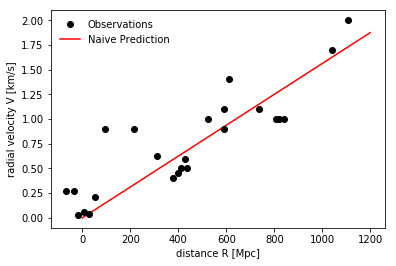

In [4]:
x = np.linspace(-1, 1200, 10000)
plt.figure()
plt.ylabel('radial velocity V [km/s]')
plt.xlabel('distance R [Mpc]')
plt.plot(array['V'], array['R'], 'ko', zorder=10, label='Observations')
plt.plot(x, fn(x,b_mle), 'r-', label=r'Naive Prediction')
plt.legend(loc='upper left', frameon=False)

We are given that Hubble had no uncertainty estimates for the data points he charted. We can use a Gaussian Process (GP) to estimate these unknown errors by making use of the marginal distribution. We seek to fit
$$ \hat{y} = R(V) + e $$
where $\hat{\cdot}$ denotes an observed value, and the (unknown) noise model follows $e \sim \mathcal{N}(0, \Sigma_y)$

In [5]:
array['R']

array([0.032, 0.034, 0.214, 0.063, 0.275, 0.275, 0.45 , 0.5  , 0.5  ,
       0.63 , 0.4  , 0.9  , 0.9  , 0.9  , 0.6  , 1.   , 1.1  , 1.1  ,
       1.4  , 1.7  , 1.   , 1.   , 1.   , 2.   ])

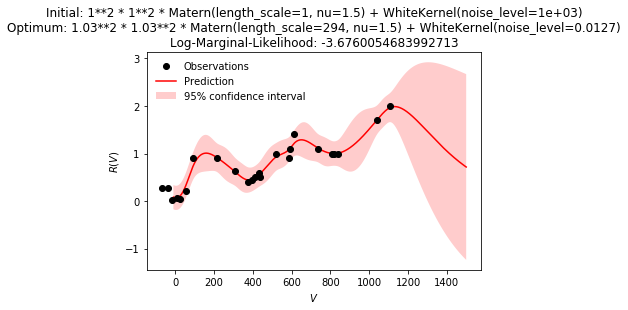

In [6]:
# noisy observations
y = np.atleast_2d(array['R']).T  # yhat = ytrue + e
X = np.atleast_2d(array['V']).T

# insatiate gaussian process
kernel = 1.0 * C(1.0, (1e-3, 1e3))*Matern(1, (1e-2, 1e4)) \
    + WhiteKernel(noise_level=1000, noise_level_bounds=(1e-10, 1e+1))
gp = GaussianProcessRegressor(kernel=kernel,
                              alpha=0.0).fit(X, y)


# for plotting, define x mesh grid
x = np.atleast_2d(np.linspace(-10, 1500, 10000)).T

# predict function
y_pred, sigma = gp.predict(x, return_std=True)

plt.figure()
plt.plot(X, y, 'ko', zorder=10, label='Observations')
plt.plot(x, y_pred, 'r-', label='Prediction')
plt.fill(np.concatenate([x, x[::-1]]), 
         np.concatenate([np.squeeze(y_pred) - 1.9600 * sigma,
         (np.squeeze(y_pred) + 1.9600 * sigma)[::-1]]),
         alpha=.2, fc='r', ec='None', label='95% confidence interval')
plt.ylabel('$R(V)$');
plt.xlabel('$V$');
#plt.ylim(-10, 20);
plt.title("Initial: %s\nOptimum: %s\nLog-Marginal-Likelihood: %s"
          % (kernel, gp.kernel_,
             gp.log_marginal_likelihood(gp.kernel_.theta)))
plt.legend(loc='upper left', frameon=False);


Here notice that we flipped the axes such that the dependent variable, $\hat{y} = R(V)$ is on the vertical axis. We observe that the mean of the gaussian process is not in fact a straight line, as the model tries to "string" the data points along in the absence of known uncertainties about the observations.

### Problem 1.2 (1pt):

The approach in 1.1 suffices to support Hubble's original finding that the universe is in fact expanding, but it is not satisfying for two reasons:

1. The GP mean function is not a straight line, in contrast to our (well: Hubble's) theoretical prejudice.
2. The variance of the data is assumed to be constant and uncorrelated: $\Sigma_{y,i}=\Sigma_y\ \forall i$.

Let's say that we are certain that the data model is linear without intercept. Then we can remedy both of these problems by specifying the analytic likelihood as a stochastic process with two sets of RVs:

$$
\begin{align}
y(x) &= b x + e(x)\\
e(x)&\sim\mathrm{GP}(\mu(x), \kappa(x,x'))
\end{align}
$$

That means we impose that data come from a linear model (with only a slope parameter and no intercept) and that the *residual errors* $e$ of the linear model come from a GP. That evidently addresses shortcoming 1, and it allows for a more flexible error model.

To visualize the approach, let's break it up into two steps.

1. Compute $e_i = R_i - \tilde{b}_{MLE} V_i$, where $\tilde{b}_{MLE}$ is the MLE of the ordinary linear regression. 
2. Perform GP regression of $e(V)$ with the same kernel as in 1.1.

In [7]:
from scipy.optimize import curve_fit
# compute the residual errors
# first find the linear regression MLE
def fn(x,b):   # linear fn, no intercept
    return b*x

pars,covm = curve_fit(fn, array['V'], array['R'])
b_mle = pars

# now compute each e_i
e = array['R'] - array['V']*b_mle   # e(V)
print('estimated residual e: ', e)

estimated residual e:  [ 0.05837563 -0.00632483  0.13154562  0.05334959  0.33048545  0.38371375
 -0.17156664 -0.13960125 -0.17819813  0.14526831 -0.18659013  0.7562792
 -0.01954821  0.56441619 -0.0706781  -0.27979513  0.17552405 -0.04870565
  0.44220156  0.07287336  0.18532244 -0.31181231 -0.25977225  0.27098833]


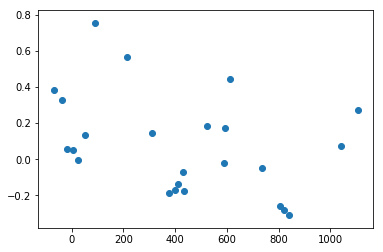

In [8]:
# now plot the residuals against the data:
plt.scatter(array['V'], e)

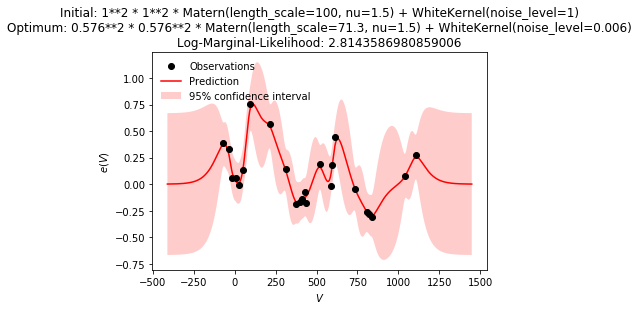

In [9]:
# now, perform the same GP analysis, this time on e(V)
# noisy observations

#initial guesses for kernel parameter
C_scale = 1.
M_scale = 100.0
WK_scale = 1.0


e = np.atleast_2d(e).T  # yhat = ytrue + e
X = np.atleast_2d(array['V']).T

# insatiate gaussian process
kernel = 1.0 * C(C_scale, (1e-3, 1e3))*Matern(M_scale, (1e-2, 1e4)) \
    + WhiteKernel(noise_level=WK_scale, noise_level_bounds=(1e-10, 1e+1))
gp = GaussianProcessRegressor(kernel=kernel,
                              alpha=0.0).fit(X, e)


# for plotting, define x mesh grid
x = np.atleast_2d(np.linspace(start=min(array['V'])-np.std(array['V']),stop = max(array['V'])+np.std(array['V']), num = 1000)).T

# predict function
e_pred, sigma = gp.predict(x, return_std=True)

plt.figure()
plt.plot(X, e, 'ko', zorder=10, label='Observations')
plt.plot(x, e_pred, 'r-', label='Prediction')
plt.fill(np.concatenate([x, x[::-1]]), 
         np.concatenate([np.squeeze(e_pred) - 1.9600 * sigma,
         (np.squeeze(e_pred) + 1.9600 * sigma)[::-1]]),
         alpha=.2, fc='r', ec='None', label='95% confidence interval')
plt.ylabel('$e(V)$');
plt.xlabel('$V$');
#plt.ylim(-10, 20);
plt.title("Initial: %s\nOptimum: %s\nLog-Marginal-Likelihood: %s"
          % (kernel, gp.kernel_,
             gp.log_marginal_likelihood(gp.kernel_.theta)))
plt.legend(loc='upper left', frameon=False);

So now the wonky shape of the GP prediction makes more sense for our problem's context. We now observe a prediction for the error in the residuals, $e(V)$, which can be highly variable as shown. We can next take this error prediction in order to perform a more informed linear regression on the (assumed) linear Hubble data.

In [10]:
# predict errors for each of the data points
error_estimate,sigma = gp.predict(X, return_std=True)
# take predicted errors and add them to a diagonal covariance matrix
sigma_matrix = np.diag(np.squeeze(error_estimate**2))

# re-fit the curve_fit module using the covariances
b_mle,covm = curve_fit(fn, array['V'], array['R'], sigma=sigma_matrix)

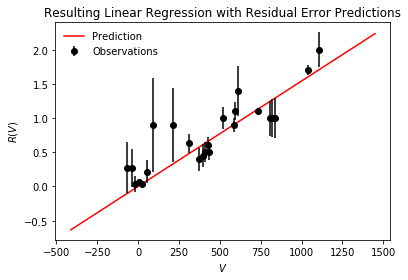

In [11]:
# fit linear regression model using the computed errors
plt.figure()
plt.errorbar(array['V'], array['R'], yerr=error_estimate, fmt='ko', zorder=10, label='Observations')
plt.plot(x, b_mle*x, 'r-', label='Prediction')
# plt.fill(np.concatenate([x, x[::-1]]),
#          np.concatenate([b_mle*x + e_pred - 1.0 * sigma,
#                         (b_mle*x+e_pred + 1.0 * sigma)[::-1]]),
#                  alpha=.2, fc='r', ec='None', label='$\pm$ 1*$\sigma$ region')
plt.legend(loc='upper left', frameon=False);
plt.xlabel("$V$")
plt.ylabel("$R(V)$")
plt.title("Resulting Linear Regression with Residual Error Predictions")
plt.show()

### Problem 1.3 (3pts): 

The linear regression errors $e$ from 1.2 appear locally clustered. These correlations of the errors can be accounted for by the GP, but so far the linear regression does not "know" of this new modeling flexibility. Let's find a way to optimize the linear model *and* the GP simultaneously.

The likelihood for the data $\lbrace(x_1,y_1),\dots,(x_N,y_N)\rbrace$ is

$$
\begin{align}
\ln p(\lbrace y_i\rbrace|\lbrace x_i \rbrace, b, \theta) &= -\frac{1}{2} e^\top K_\theta^{-1} e - \frac{1}{2}\ln|K_\theta | - \frac{N}{2}\ln(2\pi)\\
&= -\frac{1}{2}(y - b x)^\top K_\theta^{-1} (y - b x)- \frac{1}{2}\ln|K_\theta | - \frac{N}{2}\ln(2\pi)
\end{align}
$$

where $K_\theta=\kappa(x,x^\top|\theta)$ is the error covariance matrix, and $\theta$ denotes the parameter vector of the kernel function. In other words, $K$ is the covariance matrix of the $e_i$, whose parameters we seek to determine while also determining $b$ through minimizing the $e_i$.

For this to be meaningful we need to specify $\kappa$. The deviations from the mean appear locally clustered, which suggest a distance-based kernel. Like above, we'll use the robust Matérn 3/2 kernel:

$$
\kappa(x,x' | \alpha, \tau) = \alpha^2 \left(1+\frac{\sqrt{3} d}{\tau}\right)\exp\left(-\frac{\sqrt{3} d}{\tau}\right)
$$

where $d=\lVert x-x'\rVert_2$. To account for some (unknown) constant noise level, the data covariance matrix $K$ contains a diagonal term $\sigma_y^2\textbf{I}$ with the unknown noise variance $\sigma_y^2$ (that's what the `WhiteKernel` above does):

$$
K_\theta \rightarrow K_y \equiv \sigma_y^2\textbf{I} + \kappa(x,x^\top | \alpha, \tau)
$$

Implement the kernel function and the log likelihood above. Instead of a grid search, compute the gradients wrt the parameters $b$, $\sigma_y$, $\alpha$, and $\tau$ with `jax.grad`. Evaluate the gradients at $(b=0.0015, \sigma_y=0.1, \alpha=1, \tau=100)$. 

**Hints:**  

* `import jax.numpy as np`
* If you cannot install `jax`, try [`autograd`](https://github.com/HIPS/autograd) (its predecessor, installable with `pip install autograd`). Its `grad` function works just the same, but there's no built-in just-in-time compilation.

In [12]:
import jax.numpy as np
from jax import grad, hessian

In [13]:
def f(x, b):
    return b*x**2

In [14]:
def kappa(x0, x1, alpha, tau):
    return alpha**2 * (1 + np.sqrt(3)*np.linalg.norm(x0-x1) / tau) * np.exp(-np.sqrt(3)*np.linalg.norm(x0-x1) / tau)

class loglike():
    
    def __init__(self, dat):
        self.dat = dat
        
    def neg_loglike(self, param):
        x,y = self.dat
        b, sig_y, alpha, tau = param

        k = np.vectorize(lambda x0,x1: kappa(x0,x1,alpha,tau))(x[:,None], x)
        km = k + np.identity(len(y))*sig_y**2
        return (np.dot( 0.5*(y-b*x), np.linalg.solve(km, y-b*x))+0.5*np.log(np.linalg.det(km)))


In [18]:
dat = (array['V'], array['R'])
ll = loglike(dat)

print(grad(ll.neg_loglike)([0.0015, 0.1, 1.0, 100.0]))

[DeviceArray(-395.28693, dtype=float32), DeviceArray(28.359503, dtype=float32), DeviceArray(14.765713, dtype=float32), DeviceArray(-0.08914357, dtype=float32)]


### Problem 1.4 (2pt):
    
Use the gradient function from 1.3 to perform first-order gradient descent. Choose suitable step sizes and parameter initializations. 

**Hints**: 

* Make sure that all parameters stay positive.
* If needed, terminate the optimization when the value of the loss function increases.

**Response: **
Using automatic differentiation, we now have a way to compute gradients according to gradient descent:
$$  x^{t+1} = x^t - \lambda^t g(x^t)   $$
where $g(x^t)_i = \frac{\partial f(x^t)}{\partial x^t_i} \Big|_{x_1} $

In [22]:
from jax import random
import tqdm
from tqdm import tqdm_notebook
key = random.PRNGKey(0)

# Initialize random parameters
# center at previous evaluation

key, b,sigy,alpha,tau = random.split(key, 5)
param_keys = (b,sigy,alpha,tau)

params = [random.normal(p, ()) for p in param_keys]

In [20]:
params = [0.0015, 0.1, 1.0, 100.0]

In [21]:
from jax import jit, value_and_grad

@jit
def loss2(params): # simply unpack parameters
    return ll.neg_loglike(params)

@jit
def optimize(params, step_size, steps=100):
    losses = []
    for step in range(steps):
        # compute value and gradients of the loss function
        value, grads = value_and_grad(loss2)(params)
        losses.append(value)
        # update parameters with first order downhill step
        params = tuple(x - step_size * dx for x, dx in zip(params, grads))
    return params, losses

plt.figure()
for step_size in [0.01, 0.1, 1]:
    params = params
    _, losses = optimize(params, step_size)
    plt.plot(losses, label='$\lambda={}$'.format(step_size))
plt.legend();
plt.xlabel('Iteration');
plt.ylabel('Loss');

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [24]:
@jit
def update(params, step_sizes):
    grads = grad(ll.neg_loglike(params))
    return tuple(x - step_size * dx for x, dx, step_size in zip(params, grads, step_sizes))

# @jit
def optimize(params, step_sizes, steps=100):
    losses = [1e15]
    for step in tqdm_notebook(range(steps)):
        loss = ll.neg_loglike(params)
        if loss > losses[-1]:
            return params, losses
        else:
            losses.append(loss)
            params = update(params, step_sizes)
    return params, losses

In [26]:
# Compute the negative log-likelihood at a grid of values, varying one parameter at a time

b_0, sgY_0, alpha_0, tau_0 = 0.0015, 0.1, 1.0, 100.0

x_b = np.linspace(1e-5, 1e-2, 100)
y_b = []
for i in tqdm_notebook(range(len(x_b)), 'b'):
    y_b.append(ll.neg_loglike([x_b[i], sgY_0, alpha_0, tau_0]))
    
x_sgY = np.linspace(1e-5, 1, 100)
y_sgY = []
for i in tqdm_notebook(range(len(x_sgY)), 'sgY'):
    y_sgY.append(ll.neg_loglike([b_0, x_sgY[i], alpha_0, tau_0]))

x_alpha = np.linspace(1e-5, 2, 100)
y_alpha = []
for i in tqdm_notebook(range(len(x_alpha)), 'alpha'):
    y_alpha.append(ll.neg_loglike([b_0, sgY_0, x_alpha[i], tau_0]))
    
x_tau = np.linspace(1, 1000, 100)
y_tau = []
for i in tqdm_notebook(range(len(x_tau)), 'tau'):
    y_tau.append(ll.neg_loglike([b_0, sgY_0, alpha_0, x_tau[i]]))


In [ ]:
from jax import jit, value_and_grad

# define gradient descent function
class grad_descent():
    def __init__(dat, fn, step_size, change_step=False):
        self.dat = dat
        self.fn = fn
        self.step_size = step_size
        
    def grad_descent(self, param, niters):
        # compute gradients
        g = grad(fn)(self.dat, param)
        
        for n in niters:
            param -= self.step_size 
            
            
                        
            if change_step:
        
        

### Problem 1.5 (1pt):

Visualize the result:

1. Plot the matrix $K_\theta$ for the data with the parameters $\tilde\theta$ you have determined in 1.4.
2. Plot the data, the prediction mean and the $\pm1\sigma$ confidence regions. For that, compute $e = y - \tilde{b} x$, compute the mean $\mu_*$ and covariance $\Sigma_*$ of the GP for $e$. Note that the cross-covariance $K_{X*}$ does not contain a diagonal error term. The final prediction is then $\tilde{y} = \tilde{b} x + \mu_* \pm \mathrm{Diag}\left(\Sigma_*^{1/2}\right)$.